In [0]:
!pip install imgaug==0.2.5

In [0]:
!pip install Pillow==7.0.0

In [0]:
import torch
!pip install -q -U opencv-python
import cv2
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from PIL import Image

In [4]:
!git clone https://github.com/AlfredXiangWu/LightCNN.git

Cloning into 'LightCNN'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (64/64), done.


In [0]:
os.chdir("LightCNN")

DataSet

In [6]:
!git clone https://github.com/Mendru/facenet.git

Cloning into 'facenet'...
remote: Enumerating objects: 3084, done.
remote: Total 3084 (delta 0), reused 0 (delta 0), pack-reused 3084
Receiving objects: 100% (3084/3084), 164.01 MiB | 36.35 MiB/s, done.
Resolving deltas: 100% (17/17), done.


Preprocessing

In [0]:
!pip install face-recognition

In [0]:
!cp -r /content/LightCNN/facenet/CASIA-FaceV5-160/* /content/LightCNN/CASIA3/

In [0]:
import face_recognition

In [0]:
def preprocessing_first_cut():
    #print('ciao')
    directory = 'CASIA3'
    for filedir in os.listdir(directory):
        #print(directory + '/' + filedir)
        for filename in os.listdir(directory+'/'+filedir):
          #print(directory+'/'+filedir+'/'+filename)
          if filename[0] != '.':
            img_path = str(directory+'/'+filedir+'/'+filename)
            image = face_recognition.load_image_file(img_path)
            face_locations = face_recognition.face_locations(image)
            #print("****")
            #print(directory+'/'+filedir+'/'+filename)
            #print(face_locations)
            #print(image.shape)
            #print(f'There are {len(face_locations)} people in this image')

            if(len(face_locations) > 0):
              face_location = face_locations[0]
              top, right, bottom, left = face_location
              if bottom - top != 128:
                padding_vertical = 128 - (bottom - top)
              else:
                padding_vertical = 0
  
              if right - left != 128:
                padding_horizontal = 128 - ( right - left)
              else:
                padding_horizontal = 0
              
              marg_left = left - int(padding_horizontal/2)
              if marg_left < 0:
                marg_left = 0
              
              marg_top = top - int(padding_vertical/2)
              if marg_top < 0:
                marg_top = 0
              #print("l: ", left - int(padding_horizontal/2), " r:", right + int(padding_horizontal/2), " b: ", bottom + int(padding_vertical/2), " t: ", top - int(padding_vertical/2))
              face_image = image[marg_top :bottom + int(padding_vertical/2), marg_left:right + int(padding_horizontal/2)]
              pil_image = Image.fromarray(face_image)
              pil_image.save(img_path)  

In [0]:
preprocessing_first_cut()

In [0]:
def preprocessing():
    #print('ciao')
    directory = 'CASIA3'
    for filedir in os.listdir(directory):
        #print(directory + '/' + filedir)
        for filename in os.listdir(directory+'/'+filedir):
          #print(directory+'/'+filedir+'/'+filename)
          if filename[0] != '.':
            img_path = str(directory+'/'+filedir+'/'+filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
            norm_img = np.zeros((300, 300))
            image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)

            cv2.imwrite(img_path, image)

In [0]:
preprocessing()

(128, 128)


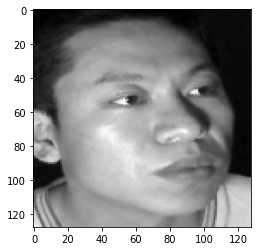

In [16]:
image = cv2.imread("CASIA3/202/202_3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

print(image.shape)
plt.imshow(image, cmap="gray")
plt.show()

Split Train, Test and Val

In [0]:
import random

In [0]:
def pp_save_clean_dataset():
    #print('ciao')
    directory = 'CASIA3'
    ftrain = open('train.txt','w+')
    fval = open('val.txt',"w+")
    ftest = open('test.txt','w+')
    jclass=0
    for filedir in os.listdir(directory):
        #print(directory + '/' + filedir)
        jclass+=1
        i = 0
        for filename in os.listdir(directory+'/'+filedir):
          #print(directory+'/'+filedir+'/'+filename)
          if filename[0] != '.':
            rnd = random.random()
            #print(rnd)
            # 70% train set, 20% val set, 10% test set.
            if rnd<.7:
              #print("rand7")
              ftrain.write( filedir+'/'+filename+' '+str(jclass)+'\n')
            elif rnd<.9:
              #print("rand9")
              fval.write( filedir+'/'+filename+' '+str(jclass)+'\n')
            else:
              #print("else")
              ftest.write( filedir+'/'+filename+' '+str(jclass)+'\n')
              i+=1
    ftrain.close()
    fval.close()
    ftest.close()
    print(jclass)

In [19]:
pp_save_clean_dataset()

501


START TRAINING

In [0]:
from light_cnn import LightCNN_9Layers, LightCNN_29Layers, LightCNN_29Layers_v2
from load_imglist import ImageList

In [0]:
train_loader = torch.utils.data.DataLoader(
        ImageList(root="CASIA3/", fileList="train.txt", 
            transform=transforms.Compose([ 
                transforms.RandomCrop(128),
                transforms.RandomHorizontalFlip(), 
                transforms.ToTensor(),
            ])),
        batch_size=32, shuffle=True,
        num_workers=16, pin_memory=True)

In [0]:
val_loader = torch.utils.data.DataLoader(
        ImageList(root="CASIA3/", fileList="val.txt", 
            transform=transforms.Compose([ 
                transforms.CenterCrop(128),
                transforms.ToTensor(),
            ])),
        batch_size=32, shuffle=False,
        num_workers=16, pin_memory=True)   

In [0]:
model = LightCNN_29Layers(num_classes=501)
model = torch.nn.DataParallel(model).cuda()
# large lr for last fc parameters
params = []
for name, value in model.named_parameters():
  if 'bias' in name:
    if 'fc2' in name:
      params += [{'params':value, 'lr': 20 * 0.01, 'weight_decay': 0}]
    else:
      params += [{'params':value, 'lr': 2 * 0.01, 'weight_decay': 0}]
  else:
    if 'fc2' in name:
      params += [{'params':value, 'lr': 10 * 0.01}]
    else:
      params += [{'params':value, 'lr': 1 * 0.01}]

weight_decay=1e-4
optimizer = torch.optim.SGD(params, 0.01,
                                momentum=0.9,
                                weight_decay=weight_decay )

Set resume to True, if there is an older model to upload

In [0]:
    resume = True
    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile("saveFolder2/lightCNN_151_checkpoint.pth.tar"):
            print("=> loading checkpoint '{}'".format("saveFolder2/lightCNN_151_checkpoint.pth.tar"))
            checkpoint = torch.load("saveFolder2/lightCNN_151_checkpoint.pth.tar")
            start_epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format("saveFolder2/lightCNN_151_checkpoint.pth.tar", checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format("saveFolder2/lightCNN_151_checkpoint.pth.tar"))

=> loading checkpoint 'saveFolder2/lightCNN_151_checkpoint.pth.tar'
=> loaded checkpoint 'saveFolder2/lightCNN_151_checkpoint.pth.tar' (epoch 151)


In [24]:
cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
criterion.cuda()

CrossEntropyLoss()

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val   = 0
        self.avg   = 0
        self.sum   = 0
        self.count = 0

    def update(self, val, n=1):
        self.val   = val
        self.sum   += val * n
        self.count += n
        self.avg   = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    scale = 0.457305051927326
    step  = 10
    lr = 0.01 * (scale ** (epoch // step))
    print('lr: {}'.format(lr))
    if (epoch != 0) & (epoch % step == 0):
        print('Change lr')
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * scale


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred    = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses     = AverageMeter()
    top1       = AverageMeter()
    top5       = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        input      = input.cuda()
        target     = target.cuda()
        input_var  = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output, _ = model(input_var)
        loss   = criterion(output, target_var)
        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1,5))
        loss_data = loss.data
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))
        top5.update(prec5.item(), input.size(0))



    print('\nTest set: Average loss: {}, Accuracy: ({})\n'.format(losses.avg, top1.avg))

    return top1.avg

In [27]:
validate(val_loader, model, criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app



Test set: Average loss: 6.2067608447210025, Accuracy: (0.20242914979757085)



0.20242914979757085

In [0]:
loss_list = []

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    top1       = AverageMeter()
    top5       = AverageMeter()

    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input      = input.cuda()
        target     = target.cuda()
        input_var  = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output, _ = model(input_var)
        loss   = criterion(output, target_var)
        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1,5))
        loss_data = loss.data
        losses.update(loss_data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))
        top5.update(prec5.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # Save variables
        loss_list.append([losses.avg, top1.avg])


        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))

In [0]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [31]:
for epoch in range(0, 502):
  adjust_learning_rate(optimizer, epoch)

  # train for one epoch
  train(train_loader, model, criterion, optimizer, epoch)

  # evaluate on validation set
  prec1 = validate(val_loader, model, criterion)

  if(epoch % 50 == 0):
    save_name = "saveFolder2/" + 'lightCNN_' + str(epoch+1) + '_checkpoint.pth.tar'
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'LightCNN',
        'state_dict': model.state_dict(),
        'prec1': prec1,
        }, save_name)

lr: 0.01
Epoch: [0][0/55]	Time 1.189 (1.189)	Data 0.580 (0.580)	Loss 6.2336 (6.2336)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app



Test set: Average loss: 6.241929355420564, Accuracy: (0.0)

lr: 0.01
Epoch: [1][0/55]	Time 0.764 (0.764)	Data 0.552 (0.552)	Loss 6.2230 (6.2230)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)

Test set: Average loss: 6.282335076737501, Accuracy: (0.0)

lr: 0.01
Epoch: [2][0/55]	Time 0.736 (0.736)	Data 0.578 (0.578)	Loss 6.1992 (6.1992)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)

Test set: Average loss: 6.306607943314773, Accuracy: (0.0)

lr: 0.01
Epoch: [3][0/55]	Time 0.762 (0.762)	Data 0.546 (0.546)	Loss 6.1976 (6.1976)	Prec@1 0.000 (0.000)	Prec@5 3.125 (3.125)

Test set: Average loss: 6.328931671405128, Accuracy: (0.0)

lr: 0.01
Epoch: [4][0/55]	Time 0.713 (0.713)	Data 0.548 (0.548)	Loss 6.2003 (6.2003)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)

Test set: Average loss: 6.373574463462058, Accuracy: (0.0)

lr: 0.01
Epoch: [5][0/55]	Time 0.726 (0.726)	Data 0.544 (0.544)	Loss 6.1940 (6.1940)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)

Test set: Average loss: 6.371350352098102, Accuracy: (0.0)


In [0]:
single_loss = []
single_acc = []

for item in loss_list:
  single_loss.append(item[0])
  single_acc.append(item[1])

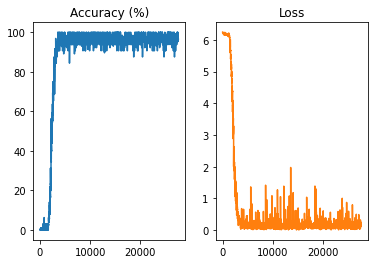

In [33]:
fig, ((ax1, ax2)) = plt.subplots(1, 2)
ax1.plot(np.arange(len(single_acc)), np.array(single_acc))
ax2.plot(np.arange(len(single_loss)), single_loss, 'tab:orange')

ax1.set_title('Accuracy (%)')
ax2.set_title('Loss')

fig.show()

In [0]:
!zip -r saveFolder3.zip saveFolder2

In [0]:
from google.colab import files
files.download("saveFolder.zip")

START EVALUATION

In [0]:
def read_list(list_path):
    img_list = []
    with open(list_path, 'r') as f:
        for line in f.readlines()[0:]:
            img_path = line.strip().split()
            img_list.append(img_path[0])
    print('There are {} images..'.format(len(img_list)))
    return img_list

def save_feature(save_path, img_name, features):
    img_path = os.path.join(save_path, img_name)
    img_dir  = os.path.dirname(img_path) + '/';
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    fname = os.path.splitext(img_path)[0]
    fname = fname + '.feat'
    fid   = open(fname, 'wb')
    fid.write(features)
    fid.close()

In [0]:
model = LightCNN_29Layers(num_classes=501)
model.eval()
model = torch.nn.DataParallel(model).cuda()

In [0]:
if os.path.isfile("saveFolder2/lightCNN_501_checkpoint.pth.tar"):
  print("=> loading checkpoint '{}'".format("saveFolder2/lightCNN_501_checkpoint.pth.tar"))
  checkpoint = torch.load("saveFolder2/lightCNN_501_checkpoint.pth.tar")
  model.load_state_dict(checkpoint['state_dict'])

In [0]:
img_list  = read_list("test.txt")
transform = transforms.Compose([transforms.ToTensor()])
count     = 0
input     = torch.zeros(1, 1, 128, 128)

In [0]:
for img_name in img_list:
  count = count + 1
  img   = cv2.imread(os.path.join("CASIA3/", img_name), cv2.IMREAD_GRAYSCALE)
  #img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_NEAREST )
  #img   = np.reshape(img, (128, 128, 1))
  img   = transform(img)
  input[0,:,:,:] = img
        
  start = time.time()
  input = input.cuda()
  input_var   = torch.autograd.Variable(input, volatile=True)
  _, features = model(input_var)
  end         = time.time() - start
  print("{}({}/{}). Time: {}".format(os.path.join("CASIA-WebFace/", img_name), count, len(img_list), end))
  save_feature("save2/", img_name, features.data.cpu().numpy()[0])


In [0]:
!zip -r saveFeatures500.zip save2